<a href="https://colab.research.google.com/github/sgulyano/aic402/blob/main/lab1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIC-402 Lab 1: Breast Cancer Analysis

CMKL University

By Sarun Gulyanon


### Goal

In this lab, we explore unsupervised learning using the Breast Cancer Wisconsin dataset. We apply dimensionality reduction and clustering techniques to discover structure in the data and evaluate the results using standard clustering metrics.

### Outline

In this lab, we will explore the following topics:

1. Loading and exploring the dataset  
2. Projecting data to a 2D plane  
3. Clustering with K-Means  
4. Selecting the number of clusters (Elbow Method)  
5. Evaluating cluster quality (Silhouette Plots)  
6. Cluster evaluation with ground-truth labels
----

# 0. Setting Up Working Environment

Install neceesary libraries

In [44]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, \
    adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics.cluster import contingency_matrix

# For reproducibility
np.random.seed(1000)

# 1. Load Dataset

This code loads the Breast Cancer Wisconsin (Diagnostic) dataset directly from the UCI Machine Learning Repository into a Pandas DataFrame.

In [45]:
bc_dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

bc_dataset_columns = ['id','diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
                      'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
                      'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
                      'radius_se','texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
                      'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
                      'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
                      'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
                      'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

# Load the dataset
df = pd.read_csv(bc_dataset_path, index_col=0, names=bc_dataset_columns).fillna(0.0)

# Show the overall statistical properties
print(df.describe())

       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

Use Seaborn to visualize pairwise relationships between selected numerical features of the dataset.

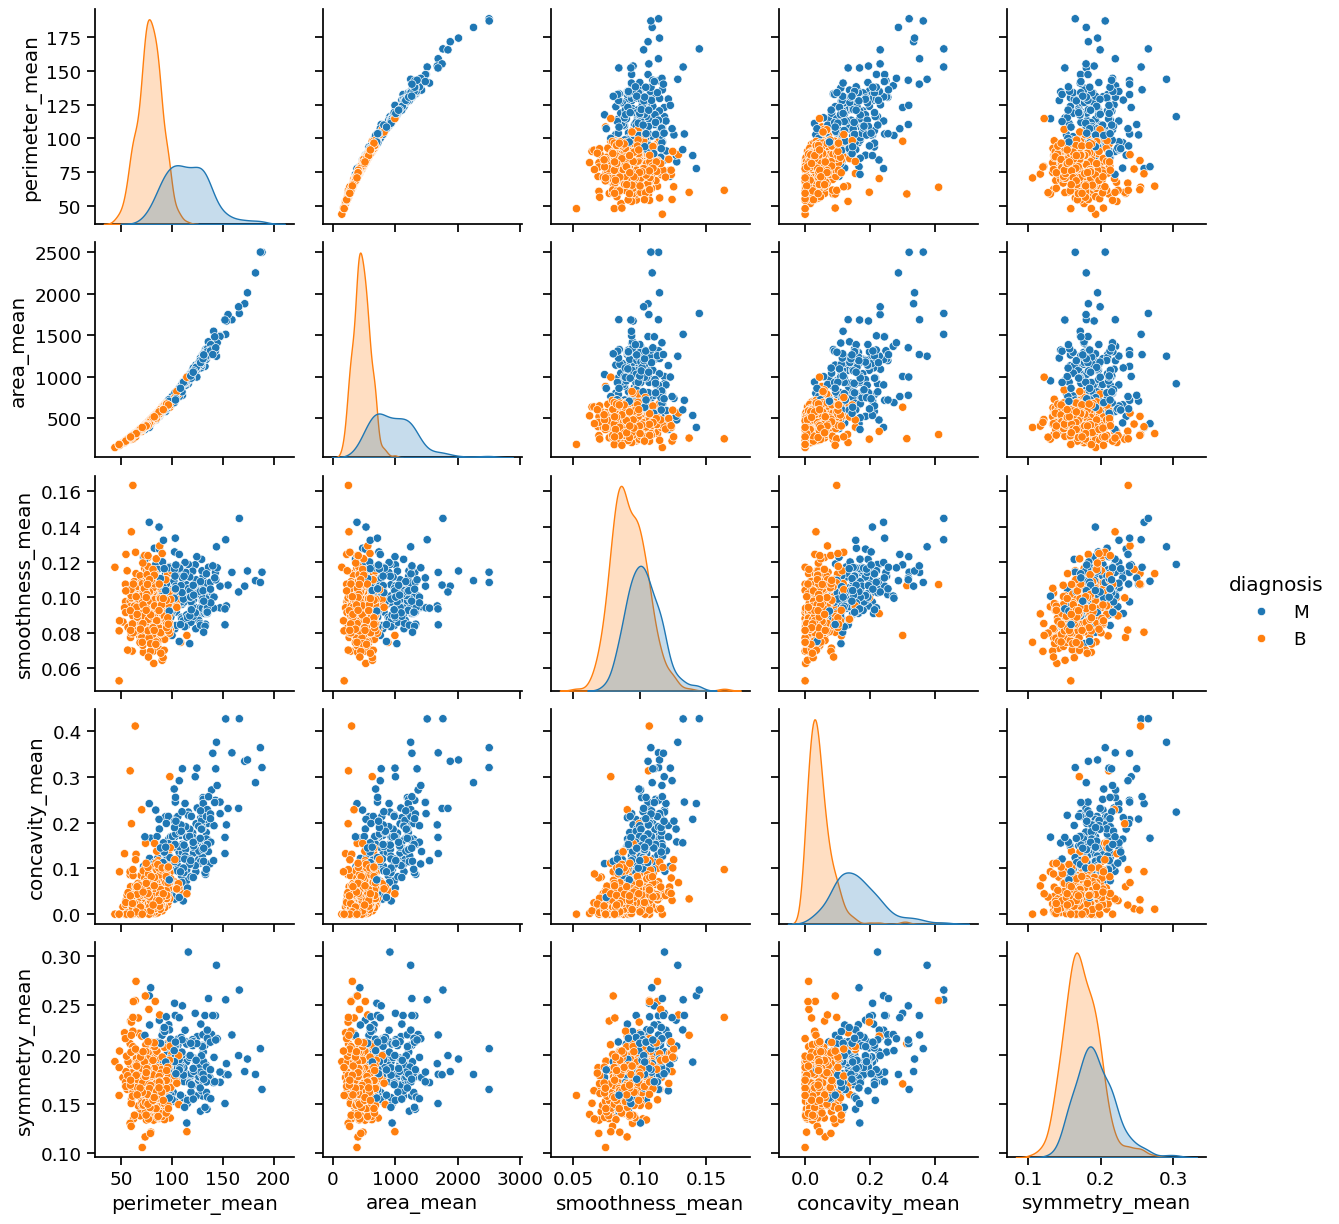

In [46]:
with sns.plotting_context("notebook", font_scale=1.2):
    sns.pairplot(df,
                 vars=['perimeter_mean', 'area_mean', 'smoothness_mean', 'concavity_mean', 'symmetry_mean'],
                 hue="diagnosis")
plt.show()

# 2. Project Data to 2D Plane
Leverage dimensionality reduction for data visualization. Apply t-SNE to project the high-dimensional data into a two-dimensional space for visualization.

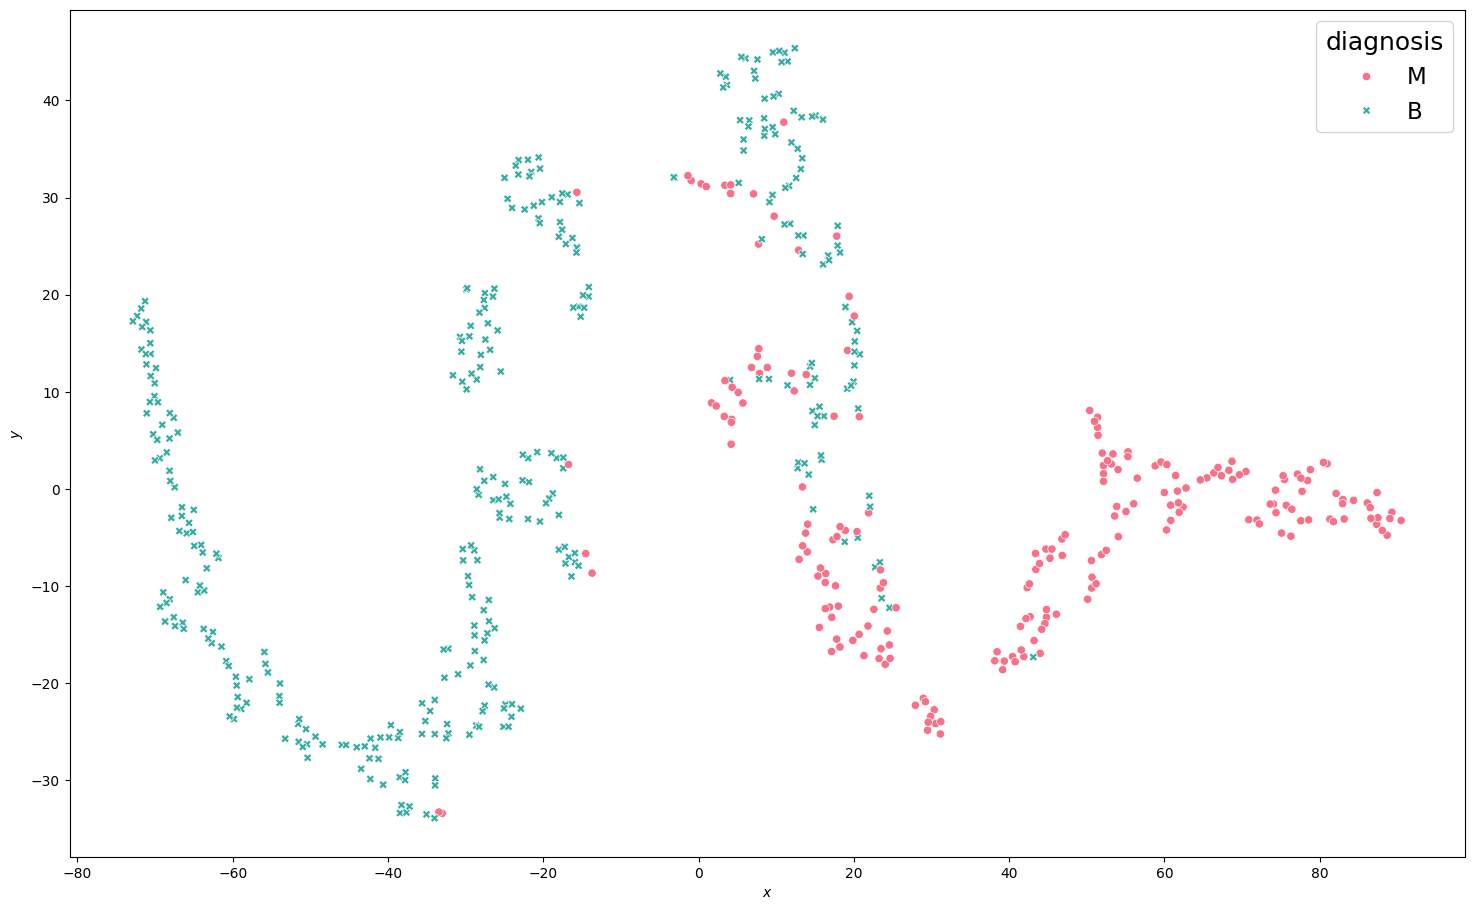

In [47]:
# Project the dataset on a bidimensional plane
cdf = df.drop(['diagnosis'], axis=1)

tsne = TSNE(n_components=2, perplexity=10, random_state=1000)
data_tsne = tsne.fit_transform(cdf)

df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'], index=cdf.index)
dff = pd.concat([df, df_tsne], axis=1)

# Show the diagram
fig, ax = plt.subplots(figsize=(18, 11))

with sns.plotting_context("notebook", font_scale=1.5):
    sns.scatterplot(x='x',
                    y='y',
                    hue='diagnosis',
                    style='diagnosis',
                    sizes=(30, 400),
                    palette=sns.color_palette("husl", 2),
                    data=dff,
                    ax=ax)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

plt.show()

# 3. Clustering

Perform clustering using K-Means method with K=2 to the original feature space to group the samples into two clusters in an unsupervised manner. This allows us to test whether an unsupervised method can recover this structure without using labels.

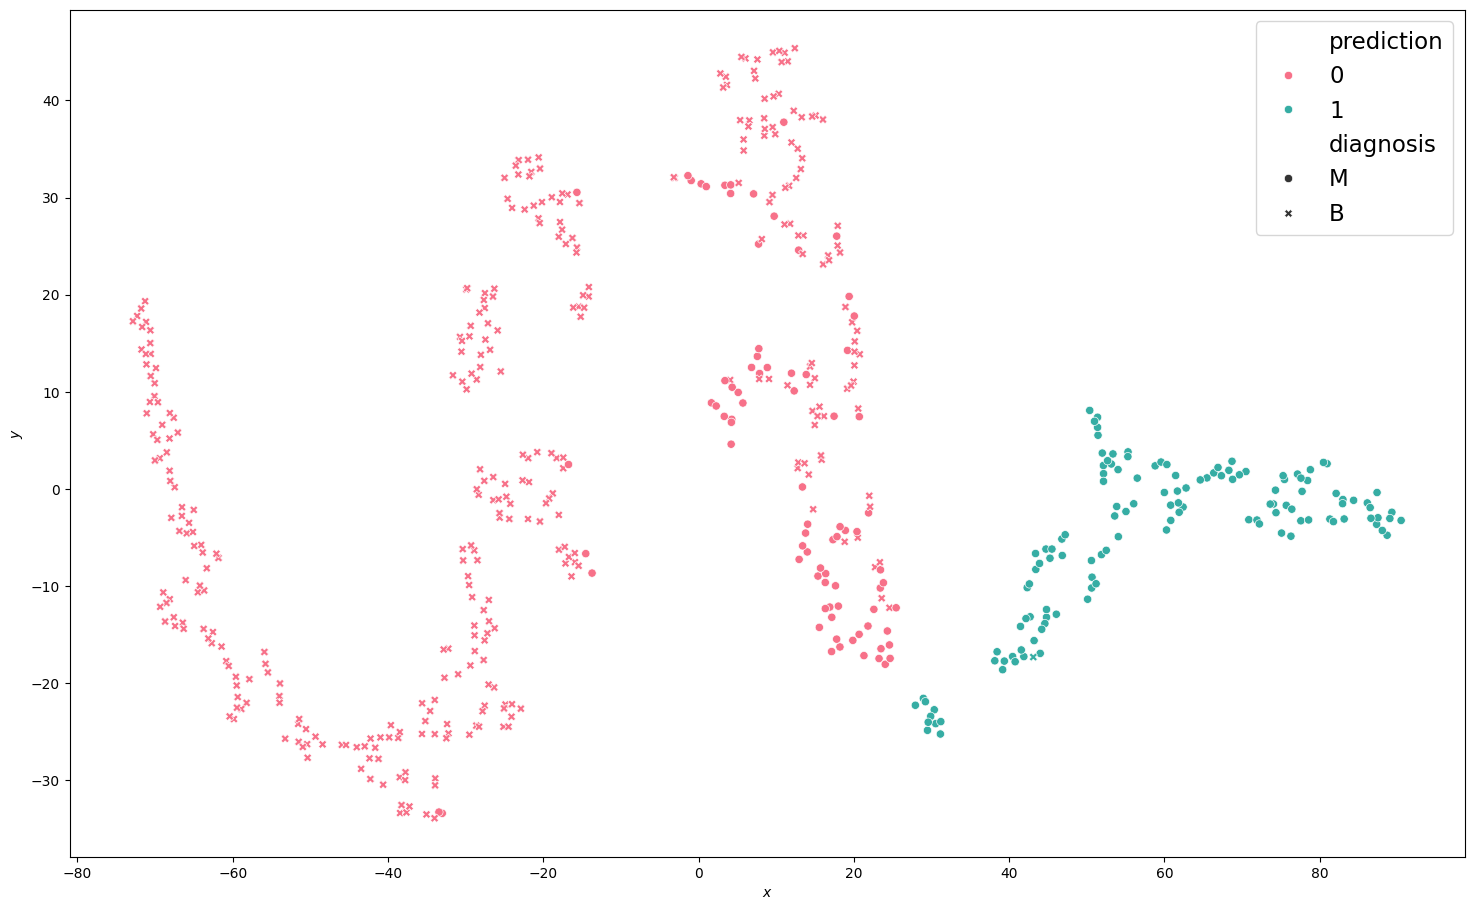

In [48]:
# Perform a K-Means clustering with K=2
km = KMeans(n_clusters=2, max_iter=1000, random_state=1000)
Y_pred = km.fit_predict(cdf)

df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
kmdff = pd.concat([dff, df_km], axis=1)

# Show the clustering result
fig, ax = plt.subplots(figsize=(18, 11))

with sns.plotting_context("notebook", font_scale=1.5):
    sns.scatterplot(x='x',
                    y='y',
                    hue='prediction',
                    style='diagnosis',
                    sizes=(30, 400),
                    palette=sns.color_palette("husl", 2),
                    data=kmdff,
                    ax=ax)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

plt.show()

# 4. Elbow Method

This code computes K-Means inertia for different numbers of clusters and plots it to show how cluster compactness improves as K increases. The curve is used with the *elbow method* to choose a reasonable number of clusters where further increases give little benefit.

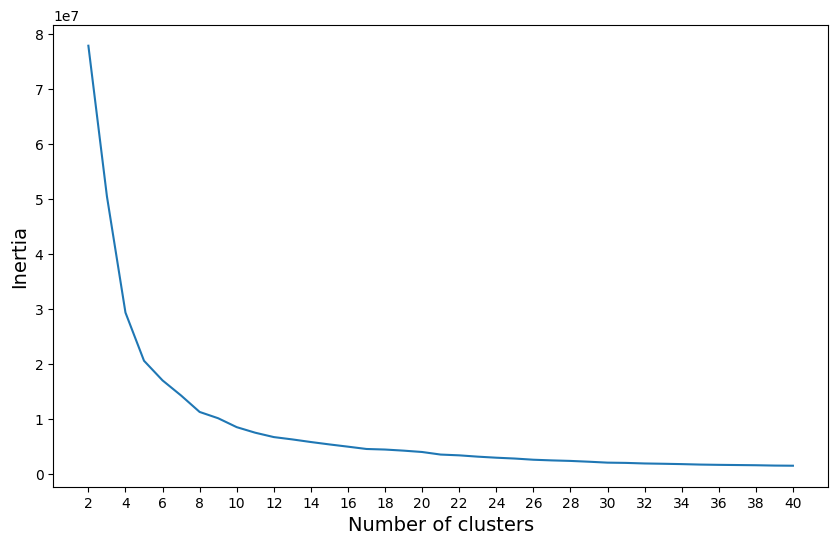

In [49]:
# Compute the inertia
inertias = []

for i in range(2, 41):
    km = KMeans(n_clusters=i, max_iter=1000, random_state=1000)
    km.fit(cdf)
    inertias.append(km.inertia_)

# Show the plot inertia vs. no. clusters
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.arange(2, 41, 1), inertias)
ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('Inertia', fontsize=14)
ax.set_xticks(np.arange(2, 41, 2))

plt.show()

# 5. Silhouette Plots

Silhouette plots visualize the silhouette scores of all data points for each cluster. They show how compact and well-separated the clusters are, making it easy to compare different numbers of clusters and identify poorly formed or overlapping clusters.

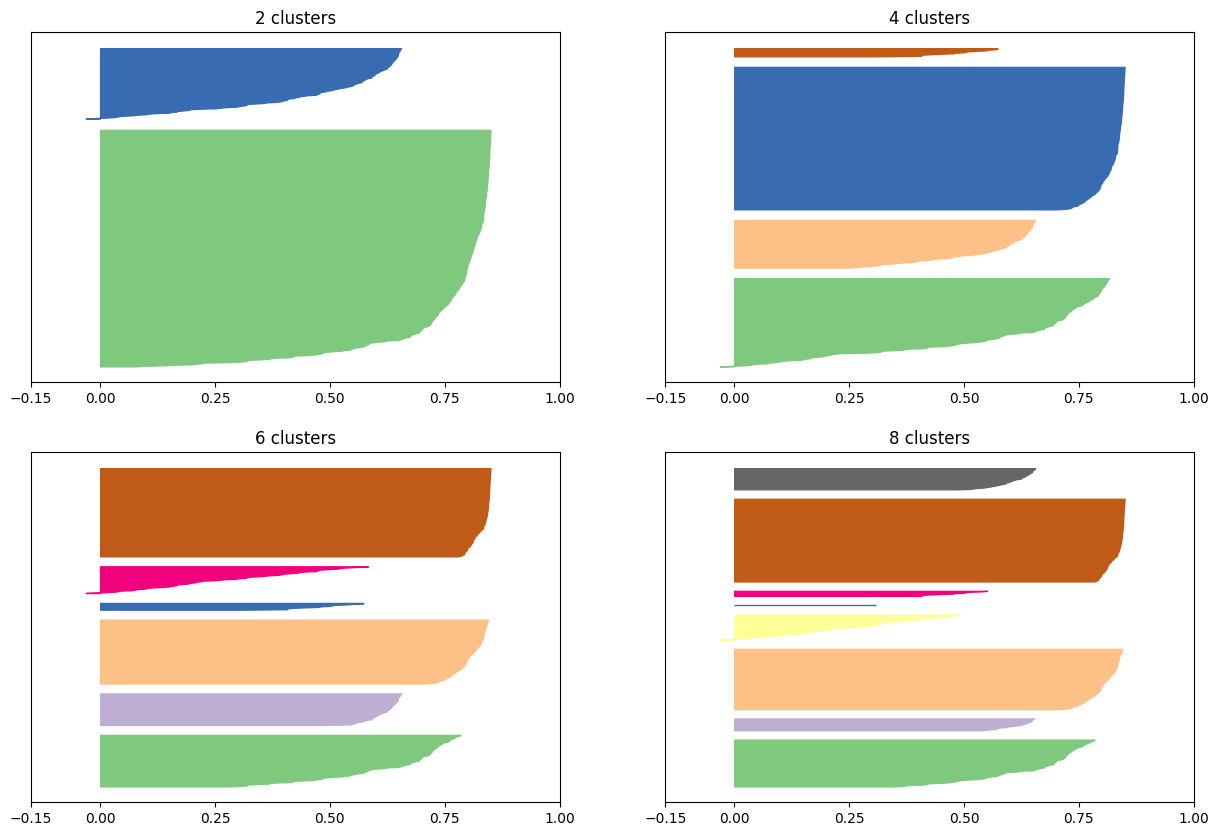

In [50]:
nb_clusters = [2, 4, 6, 8]
mapping = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Show the silhouette plots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, n in enumerate(nb_clusters):
    km = KMeans(n_clusters=n, random_state=1000)
    Y = km.fit_predict(cdf)
    df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
    kmdff = pd.concat([dff, df_km], axis=1)

    silhouette_values = silhouette_samples(cdf, kmdff['prediction'])

    ax[mapping[i]].set_xticks([-0.15, 0.0, 0.25, 0.5, 0.75, 1.0])
    ax[mapping[i]].set_yticks([])
    ax[mapping[i]].set_title('%d clusters' % n)
    ax[mapping[i]].set_xlim([-0.15, 1])
    y_lower = 20

    for t in range(n):
        ct_values = silhouette_values[Y == t]
        ct_values.sort()

        y_upper = y_lower + ct_values.shape[0]

        color = cm.Accent(float(t) / n)
        ax[mapping[i]].fill_betweenx(np.arange(y_lower, y_upper), 0, ct_values, facecolor=color, edgecolor=color)

        y_lower = y_upper + 20

plt.show()

# 6. Cluster Evaluation

We evaluate how well the unsupervised clusters match the true cancer diagnosis labels using several standard clustering metrics:

- Homogeneity:
Measures whether each cluster contains samples from only one class. A high value means clusters are “pure” (no mixing of benign and malignant samples).

- Completeness:
Measures whether all samples of the same class are assigned to the same cluster. A high value means a class is not split across multiple clusters.

- V-Score:
The harmonic mean of homogeneity and completeness, providing a balanced single summary of both criteria.

- Adjusted Mutual Information (AMI):
Quantifies how much information is shared between cluster assignments and true labels, corrected for chance. Higher values indicate better agreement.

- Adjusted Rand Index (ARI):
Measures similarity between the clustering and the ground truth based on pairwise assignments, also adjusted for chance.

To complement these numerical scores, we compute a contingency matrix and visualize it as a heatmap. This shows how many benign and malignant samples fall into each cluster, making it easier to interpret how the clusters correspond to the true classes for different values of K.

Completeness: 0.5168089972809706
Homogeneity: 0.42229071246999117
V-Score: 0.46479332792160793
Adj. Mutual info: 0.46400471284520917
Adj. Rand score: 0.49142453622455523


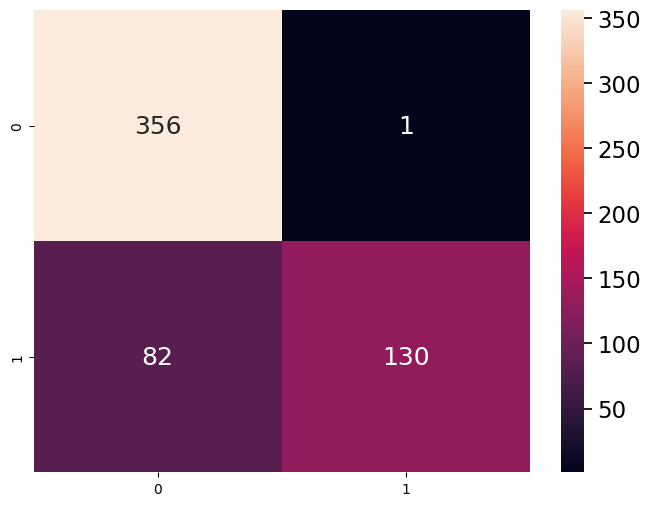

In [52]:
# Compute the other metrics for K=2
km = KMeans(n_clusters=2, max_iter=1000, random_state=1000)
Y_pred = km.fit_predict(cdf)
df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
kmdff = pd.concat([dff, df_km], axis=1)

print('Completeness: {}'.format(completeness_score(kmdff['diagnosis'], kmdff['prediction'])))
print('Homogeneity: {}'.format(homogeneity_score(kmdff['diagnosis'], kmdff['prediction'])))
print('V-Score: {}'.format(v_measure_score(kmdff['diagnosis'], kmdff['prediction'])))
print('Adj. Mutual info: {}'.format(adjusted_mutual_info_score(kmdff['diagnosis'], kmdff['prediction'])))
print('Adj. Rand score: {}'.format(adjusted_rand_score(kmdff['diagnosis'], kmdff['prediction'])))

# Compute and show the contingency matrix
cm = contingency_matrix(kmdff['diagnosis'].apply(lambda x: 0 if x == 'B' else 1), kmdff['prediction'])

fig, ax = plt.subplots(figsize=(8, 6))

with sns.plotting_context("notebook", font_scale=1.5):
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)

plt.show()

Completeness: 0.24607829982502963
Homogeneity: 0.6307052465295893
V-Score: 0.3540277994540628
Adj. Mutual info: 0.35042088082434303
Adj. Rand score: 0.25918588465410136


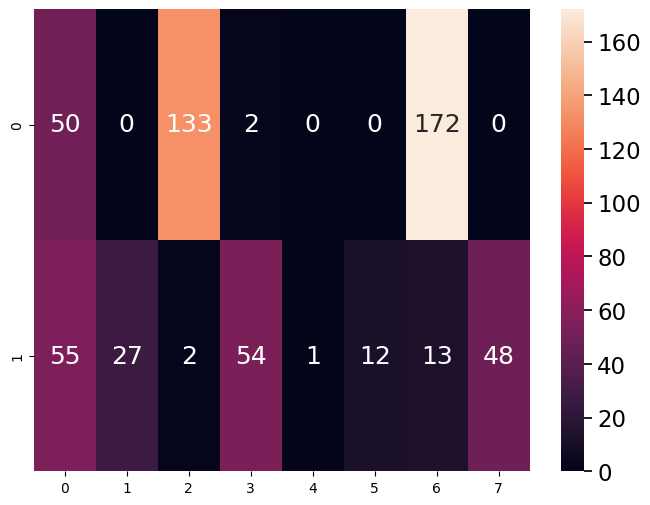

In [53]:
# Compute the other metrics for K=8
km = KMeans(n_clusters=8, max_iter=1000, random_state=1000)
Y_pred = km.fit_predict(cdf)
df_km = pd.DataFrame(Y_pred, columns=['prediction'], index=cdf.index)
kmdff = pd.concat([dff, df_km], axis=1)

print('Completeness: {}'.format(completeness_score(kmdff['diagnosis'], kmdff['prediction'])))
print('Homogeneity: {}'.format(homogeneity_score(kmdff['diagnosis'], kmdff['prediction'])))
print('V-Score: {}'.format(v_measure_score(kmdff['diagnosis'], kmdff['prediction'])))
print('Adj. Mutual info: {}'.format(adjusted_mutual_info_score(kmdff['diagnosis'], kmdff['prediction'])))
print('Adj. Rand score: {}'.format(adjusted_rand_score(kmdff['diagnosis'], kmdff['prediction'])))

# Compute and show the contingency matrix
cm = contingency_matrix(kmdff['diagnosis'].apply(lambda x: 0 if x == 'B' else 1), kmdff['prediction'])

fig, ax = plt.subplots(figsize=(8, 6))

with sns.plotting_context("notebook", font_scale=1.5):
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)

plt.show()

---